# This algorithm calculates reals points in CCS from GEODE écarts

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy import linalg as LA
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.style.use('ggplot')

In [2]:
btp_points_faisceaux = pd.read_csv('points_faisceaux/btp_points_faisceaux.csv', skiprows=0, encoding='latin1').fillna(0)
btp_points_faisceaux.drop(["Accl.", "Zone", "Dist. cumul. (m)", "Corhgeo (m)", "Date_Calcul", "Comm", "Type longueur", "Id point ", "Id SU assemb.", "Id slot", "Nom Layout", "Source"], axis=1, inplace=True)
btp_ecarts = pd.read_csv('points_faisceaux/btp_ecarts.csv', skiprows=0, encoding='latin1').fillna(0)
btp_ecarts.drop(["Accl.", "Zone", "Type", "Date R", "Valeur R Bump", "Date V", "Valeur V Bump","Date L", "Valeur L Bump", "Date T", "Valeur T Bump", "Id.", "Dist. Cum. (m)", "Commentaires R", "Commentaires V", "Commentaires L", "Nom Layout", "Inséré Par"], axis=1, inplace=True)

In [3]:
btp_points_faisceaux.head(1)

Elément       X (m)       Y (m)    Z (m) Longueur (m)  \
0  BTPSTART.0.E  1894.86806  2121.31165  2433.66            -   

   Tilt faisceau (rad)  1/2 Déflexion (rad)  Gisement (gon)  \
0                  0.0                  0.0       28.614221   

   Pente faisceau (rad)  
0                   0.0

In [4]:
btp_ecarts.head(1)

Elément  Valeur R (m)  Valeur V (m)  Valeur T (rad)  Valeur L (m)
0  BTBHZ.10.E     -0.000017      -0.00181       -0.000284     -0.000753

Let's merge the two dataframes together and fill elements which have not have had a measurement with zeroes

In [5]:
btp_merged = pd.merge(btp_points_faisceaux, btp_ecarts, on="Elément", how="left")
btp_merged["Gisement (rad)"] = btp_merged["Gisement (gon)"]*np.pi/200
btp_merged = btp_merged.fillna(0)
btp_merged.head(3)

Elément       X (m)       Y (m)    Z (m) Longueur (m)  \
0  BTPSTART.0.E  1894.86806  2121.31165  2433.66            -   
1  BTPSTART.0.S  1894.86806  2121.31165  2433.66      0.00000   
2    BTBHZ.10.E  1894.91119  2121.40105  2433.66            -   

   Tilt faisceau (rad)  1/2 Déflexion (rad)  Gisement (gon)  \
0                  0.0             0.000000       28.614221   
1                  0.0             0.000000       28.614221   
2                  0.0            -0.078545       28.614221   

   Pente faisceau (rad)  Valeur R (m)  Valeur V (m)  Valeur T (rad)  \
0                   0.0      0.000000       0.00000        0.000000   
1                   0.0      0.000000       0.00000        0.000000   
2                   0.0     -0.000017      -0.00181       -0.000284   

   Valeur L (m)  Gisement (rad)  
0      0.000000        0.449471  
1      0.000000        0.449471  
2     -0.000753        0.449471

In [6]:
btp_merged_copy = btp_merged.copy()

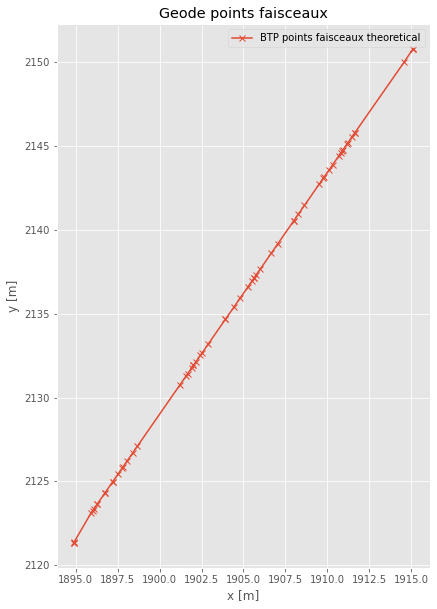

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title("Geode points faisceaux")
ax.plot(btp_merged["X (m)"], btp_merged["Y (m)"], marker="x", label = "BTP points faisceaux theoretical")
ax.set_aspect('equal')
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.legend()

In [8]:
btp_merged["dx_rad"] = -btp_merged["Valeur R (m)"]*np.cos(btp_merged["Gisement (rad)"])
btp_merged["dy_rad"] = btp_merged["Valeur R (m)"]*np.sin(btp_merged["Gisement (rad)"])

btp_merged["dx_long"] = btp_merged["Valeur L (m)"]*np.sin(btp_merged["Gisement (rad)"])
btp_merged["dy_long"] = btp_merged["Valeur L (m)"]*np.cos(btp_merged["Gisement (rad)"])

btp_merged["dx"] = np.add( btp_merged["dx_rad"] , btp_merged["dx_long"] )
btp_merged["dy"] = np.add( btp_merged["dy_rad"] , btp_merged["dy_long"] )

btp_merged["X réel CCS (m)"] = np.add(btp_merged["X (m)"], btp_merged["dx"])
btp_merged["Y réel CCS (m)"] = np.add(btp_merged["Y (m)"], btp_merged["dy"])
btp_merged["Z réel CCS (m)"] = np.add(btp_merged["Z (m)"], btp_merged["Valeur V (m)"])

In [9]:
btp_merged.head(4)

Elément       X (m)       Y (m)    Z (m) Longueur (m)  \
0  BTPSTART.0.E  1894.86806  2121.31165  2433.66            -   
1  BTPSTART.0.S  1894.86806  2121.31165  2433.66      0.00000   
2    BTBHZ.10.E  1894.91119  2121.40105  2433.66            -   
3    BTBHZ.10.S  1895.91803  2123.12729  2433.66      2.00046   

   Tilt faisceau (rad)  1/2 Déflexion (rad)  Gisement (gon)  \
0                  0.0             0.000000       28.614221   
1                  0.0             0.000000       28.614221   
2                  0.0            -0.078545       28.614221   
3                  0.0            -0.078545       38.614852   

   Pente faisceau (rad)  Valeur R (m)  ...  Gisement (rad)    dx_rad  \
0                   0.0      0.000000  ...        0.449471 -0.000000   
1                   0.0      0.000000  ...        0.449471 -0.000000   
2                   0.0     -0.000017  ...        0.449471  0.000015   
3                   0.0     -0.000086  ...        0.606561  0.000071   

     dy_rad   dx_long   dy_long        dx        dy  X réel CCS (m)  \
0  0.000000  0.000000  0.000000  0.000000  0.000000     1894.868060   
1  0.000000  0.000000  0.000000  0.000000  0.000000     1894.868060   
2 -0.000007 -0.000327 -0.000678 -0.000312 -0.000686     1894.910878   
3 -0.000049 -0.000429 -0.000619 -0.000359 -0.000668     1895.917671   

   Y réel CCS (m)  Z réel CCS (m)  
0     2121.311650     2433.660000  
1     2121.311650     2433.660000  
2     2121.400364     2433.658190  
3     2123.126622     2433.658209  

[4 rows x 23 columns]

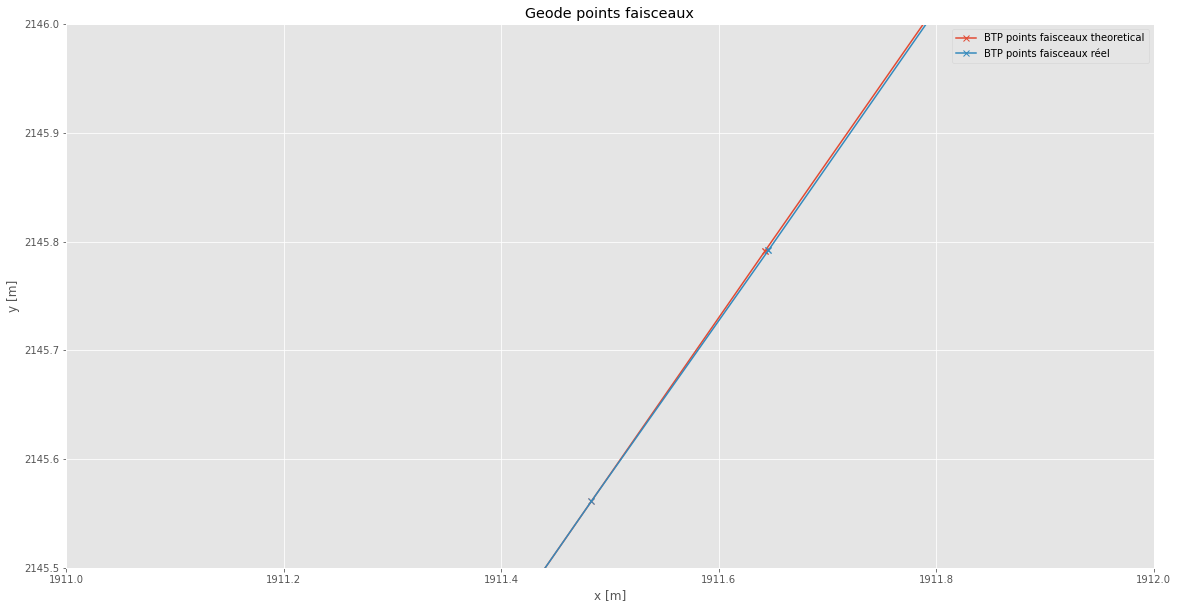

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Geode points faisceaux")
ax.plot(btp_merged["X (m)"], btp_merged["Y (m)"], marker="x", label = "BTP points faisceaux theoretical")
ax.plot(btp_merged["X réel CCS (m)"], btp_merged["Y réel CCS (m)"], marker="x", label = "BTP points faisceaux réel")
ax.set_aspect('equal')
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim(1911,1912)
plt.ylim(2145.5,2146)
plt.legend()

## For completness and for check, you could use a different technique for angle calculation

This requires a lot of extra calculation and isn't as elegant.

In [11]:
btp_merged_copy.head(1)

Elément       X (m)       Y (m)    Z (m) Longueur (m)  \
0  BTPSTART.0.E  1894.86806  2121.31165  2433.66            -   

   Tilt faisceau (rad)  1/2 Déflexion (rad)  Gisement (gon)  \
0                  0.0                  0.0       28.614221   

   Pente faisceau (rad)  Valeur R (m)  Valeur V (m)  Valeur T (rad)  \
0                   0.0           0.0           0.0             0.0   

   Valeur L (m)  Gisement (rad)  
0           0.0        0.449471

In [12]:
def dx_rad(x):
    gisement = x["Gisement (rad)"]
    R = x["Valeur R (m)"]
    
    if (gisement <= np.pi/2):
        dx_rad = -R*np.cos(gisement)
        
    if (gisement > np.pi/2 <= np.pi):
        dx_rad = R*np.sin(gisement-np.pi/2)
    
    if (gisement > np.pi <= 3*np.pi/2):
        dx_rad = R*np.cos(gisement-np.pi)
        
    if (gisement > 3*np.pi/2):
        dx_rad = -R*np.sin(gisement-3*np.pi/2)
    
    return dx_rad

def dy_rad(x):
    gisement = x["Gisement (rad)"]
    R = x["Valeur R (m)"]
    
    if (gisement <= np.pi/2):
        dy_rad = R*np.sin(gisement)
        
    if (gisement > np.pi/2 <= np.pi):
        dy_rad = R*np.cos(gisement-np.pi/2)
    
    if (gisement > np.pi <= 3*np.pi/2):
        dy_rad = -R*np.sin(gisement-np.pi)
        
    if (gisement > 3*np.pi/2):
        dy_rad = -R*np.cos(gisement-3*np.pi/2)
    
    return dy_rad

def dx_long(x):
    gisement = x["Gisement (rad)"]
    L = x["Valeur L (m)"]
    
    if (gisement <= np.pi/2):
        dx_long = L*np.sin(gisement)
        
    if (gisement > np.pi/2 <= np.pi):
        dx_long = L*np.cos(gisement-np.pi/2)
    
    if (gisement > np.pi <= 3*np.pi/2):
        dx_long = -L*np.sin(gisement-np.pi)
        
    if (gisement > 3*np.pi/2):
        dx_long = -L*np.cos(gisement-3*np.pi/2)
    
    return dx_long

def dy_long(x):
    gisement = x["Gisement (rad)"]
    L = x["Valeur L (m)"]
    
    if (gisement <= np.pi/2):
        dy_long = L*np.cos(gisement)
        
    if (gisement > np.pi/2 <= np.pi):
        dy_long = -L*np.sin(gisement-np.pi/2)
    
    if (gisement > np.pi <= 3*np.pi/2):
        dy_long = -L*np.cos(gisement-np.pi)
        
    if (gisement > 3*np.pi/2):
        dy_long = L*np.sin(gisement-3*np.pi/2)
    
    return dy_long

In [13]:
btp_merged_copy["dx_rad"] = btp_merged_copy.apply(dx_rad, axis=1)
btp_merged_copy["dy_rad"] = btp_merged_copy.apply(dy_rad, axis=1)
btp_merged_copy["dx_long"] = btp_merged_copy.apply(dx_long, axis=1)
btp_merged_copy["dy_long"] = btp_merged_copy.apply(dy_long, axis=1)

btp_merged_copy["dx"] = np.add(btp_merged_copy["dx_rad"], btp_merged_copy["dx_long"])
btp_merged_copy["dy"] = np.add(btp_merged_copy["dy_rad"], btp_merged_copy["dy_long"])

btp_merged_copy["X réel CCS (m)"] = np.add(btp_merged_copy["X (m)"], btp_merged_copy["dx"])
btp_merged_copy["Y réel CCS (m)"] = np.add(btp_merged_copy["Y (m)"], btp_merged_copy["dy"])
btp_merged_copy["Z réel CCS (m)"] = np.add(btp_merged_copy["Z (m)"], btp_merged_copy["Valeur V (m)"])

In [14]:
btp_merged_copy.head(1)

Elément       X (m)       Y (m)    Z (m) Longueur (m)  \
0  BTPSTART.0.E  1894.86806  2121.31165  2433.66            -   

   Tilt faisceau (rad)  1/2 Déflexion (rad)  Gisement (gon)  \
0                  0.0                  0.0       28.614221   

   Pente faisceau (rad)  Valeur R (m)  ...  Gisement (rad)  dx_rad  dy_rad  \
0                   0.0           0.0  ...        0.449471    -0.0     0.0   

   dx_long  dy_long   dx   dy  X réel CCS (m)  Y réel CCS (m)  Z réel CCS (m)  
0      0.0      0.0  0.0  0.0      1894.86806      2121.31165         2433.66  

[1 rows x 23 columns]

In [15]:
btp_merged_copy.equals(btp_merged)

True

So it's confirmed they are in fact the same

# Let's check with values from Camille

In [16]:
camille_points = pd.read_csv('points_faisceaux/calcul_points_reels_par_camille.csv', skiprows=1, sep=';', encoding='latin1')
camille_merged = pd.merge(camille_points, btp_merged, on="Elément", how="left").fillna(0)
camille_merged.head(4)

Accl.       Elément      X (m)_x      Y (m)_x  Z (m)_x  \
0   BTP  BTPSTART.0.E   1894,86806  2121,311646  2433,66   
1   BTP  BTPSTART.0.S   1894,86806  2121,311646  2433,66   
2   BTP    BTBHZ.10.E   1894,91119  2121,401053  2433,66   
3   BTP    BTBHZ.10.S  1895,918026  2123,127289  2433,66   

   Tilt faisceau (rad)_x Gisement (gon)_x Gisement modulé (rad)  \
0                      0        28,614221           0,449471132   
1                      0        28,614221           0,449471132   
2                      0        28,614221           0,449471132   
3                      0        38,614852           0,606560677   

   Pente faisceau (rad)_x Valeur R (m)_x  ...  Gisement (rad)    dx_rad  \
0                       0              0  ...        0.449471 -0.000000   
1                       0              0  ...        0.449471 -0.000000   
2                       0      -0,000017  ...        0.449471  0.000015   
3                       0      -0,000086  ...        0.606561  0.000071   

     dy_rad   dx_long   dy_long      dx_y      dy_y  X réel CCS (m)  \
0  0.000000  0.000000  0.000000  0.000000  0.000000     1894.868060   
1  0.000000  0.000000  0.000000  0.000000  0.000000     1894.868060   
2 -0.000007 -0.000327 -0.000678 -0.000312 -0.000686     1894.910878   
3 -0.000049 -0.000429 -0.000619 -0.000359 -0.000668     1895.917671   

  Y réel CCS (m) Z réel CCS (m)  
0    2121.311650    2433.660000  
1    2121.311650    2433.660000  
2    2121.400364    2433.658190  
3    2123.126622    2433.658209  

[4 rows x 53 columns]

In [17]:
camille_merged["X reel CCS (m)"] = camille_merged["X reel CCS (m)"].str.replace(',','.')
camille_merged["X reel CCS (m)"] = camille_merged["X reel CCS (m)"].fillna(0)
camille_merged["X reel CCS (m)"] = pd.to_numeric(camille_merged["X reel CCS (m)"], downcast="float")

In [18]:
camille_merged["Y reel CCS (m)"] = camille_merged["Y reel CCS (m)"].str.replace(',','.')
camille_merged["Y reel CCS (m)"] = camille_merged["Y reel CCS (m)"].fillna(0)
camille_merged["Y reel CCS (m)"] = pd.to_numeric(camille_merged["Y reel CCS (m)"], downcast="float")

In [19]:
diffX = camille_merged["X réel CCS (m)"]- camille_merged["X reel CCS (m)"]
diffY = camille_merged["X réel CCS (m)"]- camille_merged["X reel CCS (m)"]

In [20]:
print (min(diffX.loc[diffX < 1000].sort_values(ascending=True)), max(diffX.loc[diffY < 1000].sort_values(ascending=True)))

-6.26011328677123e-05 6.080742355152324e-05


In [21]:
print (min(diffY.loc[diffY < 1000].sort_values(ascending=True)), max(diffY.loc[diffY < 1000].sort_values(ascending=True)))

-6.26011328677123e-05 6.080742355152324e-05


So we see that the largest difference is -63 +61 micrometer which is due to rounding in excel